In [1]:
'''Train CIFAR10 with PyTorch.'''
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
import os
!pip install torchinfo
from torchinfo import summary
# from models import *
# from utils import progress_bar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch

In [3]:
# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.3, hue=0.3),
    #transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
    #transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
    #transforms.GaussianBlur(3, sigma=(0.1, 2.0)),  # augmentation
    
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

==> Preparing data..


In [4]:
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2) #128

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2) #100

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
print(len(trainloader))

391


In [6]:
# Model
print('==> Building model..')


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



==> Building model..


In [7]:
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [8]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        #self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(1024*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        #out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


In [9]:
net = ResNet(BasicBlock, [3, 4, 3, 3])

print(summary(net,input_size=(128,3,32,32)))#input_size = (batch_size, #channel,imgsize)
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [128, 10]                 --
├─Conv2d: 1-1                            [128, 64, 32, 32]         1,728
├─BatchNorm2d: 1-2                       [128, 64, 32, 32]         128
├─Sequential: 1-3                        [128, 64, 32, 32]         --
│    └─BasicBlock: 2-1                   [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-1                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-2             [128, 64, 32, 32]         128
│    │    └─Conv2d: 3-3                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-4             [128, 64, 32, 32]         128
│    │    └─Sequential: 3-5              [128, 64, 32, 32]         --
│    └─BasicBlock: 2-2                   [128, 64, 32, 32]         --
│    │    └─Conv2d: 3-6                  [128, 64, 32, 32]         36,864
│    │    └─BatchNorm2d: 3-7             [128, 64, 32, 32]         

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001,weight_decay=6e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [11]:
# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        print('Train Epoch: %d | Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (epoch, train_loss/(batch_idx+1), 100.*correct/total, correct, total))

        # progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        #              % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
    return train_loss/(batch_idx+1), 100.*correct/total

In [12]:
def test(epoch):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            print('Test Epoch: %d | Loss: %.3f | Acc: %.3f%% (%d/%d)'
                  % (epoch, test_loss/(batch_idx+1), 100.*correct/total, correct, total))
            # progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            #              % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'):
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc
    return test_loss/(batch_idx+1), acc

In [13]:
acc_list = []
loss_list = []
for epoch in range(start_epoch, start_epoch+150):
    train(epoch)
    loss, acc = test(epoch)
    acc_list.append(acc)
    loss_list.append(loss)
    scheduler.step()

流式输出内容被截断，只能显示最后 5000 行内容。
Test Epoch: 139 | Loss: 0.305 | Acc: 91.588% (3114/3400)
Test Epoch: 139 | Loss: 0.305 | Acc: 91.543% (3204/3500)
Test Epoch: 139 | Loss: 0.306 | Acc: 91.583% (3297/3600)
Test Epoch: 139 | Loss: 0.312 | Acc: 91.459% (3384/3700)
Test Epoch: 139 | Loss: 0.315 | Acc: 91.342% (3471/3800)
Test Epoch: 139 | Loss: 0.311 | Acc: 91.462% (3567/3900)
Test Epoch: 139 | Loss: 0.310 | Acc: 91.475% (3659/4000)
Test Epoch: 139 | Loss: 0.311 | Acc: 91.415% (3748/4100)
Test Epoch: 139 | Loss: 0.310 | Acc: 91.429% (3840/4200)
Test Epoch: 139 | Loss: 0.305 | Acc: 91.558% (3937/4300)
Test Epoch: 139 | Loss: 0.305 | Acc: 91.614% (4031/4400)
Test Epoch: 139 | Loss: 0.305 | Acc: 91.689% (4126/4500)
Test Epoch: 139 | Loss: 0.303 | Acc: 91.630% (4215/4600)
Test Epoch: 139 | Loss: 0.300 | Acc: 91.723% (4311/4700)
Test Epoch: 139 | Loss: 0.305 | Acc: 91.604% (4397/4800)
Test Epoch: 139 | Loss: 0.301 | Acc: 91.694% (4493/4900)
Test Epoch: 139 | Loss: 0.309 | Acc: 91.580% (4579/5000)
Test

In [18]:
for epoch in range(start_epoch, start_epoch+50):
    train(epoch)
    loss, acc = test(epoch)
    acc_list.append(acc)
    loss_list.append(loss)
    scheduler.step()

流式输出内容被截断，只能显示最后 5000 行内容。
Test Epoch: 39 | Loss: 0.311 | Acc: 92.645% (2872/3100)
Test Epoch: 39 | Loss: 0.312 | Acc: 92.625% (2964/3200)
Test Epoch: 39 | Loss: 0.308 | Acc: 92.636% (3057/3300)
Test Epoch: 39 | Loss: 0.310 | Acc: 92.588% (3148/3400)
Test Epoch: 39 | Loss: 0.312 | Acc: 92.543% (3239/3500)
Test Epoch: 39 | Loss: 0.312 | Acc: 92.583% (3333/3600)
Test Epoch: 39 | Loss: 0.320 | Acc: 92.459% (3421/3700)
Test Epoch: 39 | Loss: 0.321 | Acc: 92.395% (3511/3800)
Test Epoch: 39 | Loss: 0.316 | Acc: 92.487% (3607/3900)
Test Epoch: 39 | Loss: 0.315 | Acc: 92.500% (3700/4000)
Test Epoch: 39 | Loss: 0.318 | Acc: 92.488% (3792/4100)
Test Epoch: 39 | Loss: 0.318 | Acc: 92.500% (3885/4200)
Test Epoch: 39 | Loss: 0.311 | Acc: 92.651% (3984/4300)
Test Epoch: 39 | Loss: 0.313 | Acc: 92.614% (4075/4400)
Test Epoch: 39 | Loss: 0.311 | Acc: 92.644% (4169/4500)
Test Epoch: 39 | Loss: 0.312 | Acc: 92.674% (4263/4600)
Test Epoch: 39 | Loss: 0.310 | Acc: 92.723% (4358/4700)
Test Epoch: 39 | Loss

In [19]:
print(best_acc)

92.86


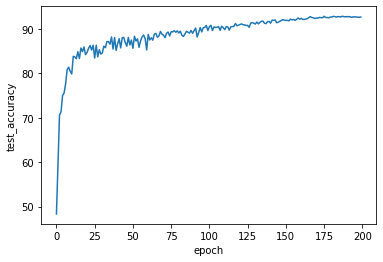

In [20]:
import matplotlib.pyplot as plt

plt.plot(acc_list)
plt.xlabel("epoch")
plt.ylabel("test_accuracy")
plt.show()

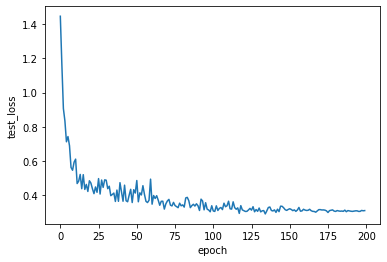

In [21]:
plt.plot(loss_list)
plt.xlabel("epoch") 
plt.ylabel("test_loss")
plt.show()

In [22]:
net

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       